# load libraries
import pandas as pd
from pandasql import sqldf

In [1]:
import pandas as pd
from pandasql import sqldf

In [2]:
# load ExcelFile
xl = pd.ExcelFile(r"C:\Users\LW130003\Desktop\IOD - Exploratory Data Analysis Test - Environmental Dataset.xlsx")
xl.sheet_names

['Data', 'Metadata - Countries', 'Metadata - Indicators']

In [3]:
# Parsing to Dataframe
data = xl.parse('Data', header=3)
countries = xl.parse('Metadata - Countries')
indicators = xl.parse('Metadata - Indicators')

In [4]:
indicators.columns

Index(['Indicator Code', 'Indicator Name', 'Source Note',
       'Source Organization'],
      dtype='object')

In [5]:
data.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015'],
      dtype='object')

In [6]:
countries.columns

Index(['Country Name', 'Country Code', 'Region', 'Income Group',
       'Special Notes'],
      dtype='object')

We have 'Country Code' as primary key for countries data frame and 'Indicator Code' as primary key for indicators data frame. Let's rename the column as spacing could give problem in SQL commands. We will also reshape the data dataset from wide to long.

In [7]:
# Wide to Long
data = pd.melt(data, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
# Rename
data.rename(index=str, columns={'Country Name':'Country_Name', 'Country Code':'Country_Code', 
                                'Indicator Name':'Indicator_Name', 'Indicator Code':'Indicator_Code', 'variable':'year'}, inplace = True)
indicators.rename(index=str, columns={'Indicator Code':'id', 'Indicator Name':'name', 
                                      'Source Note':'Source_Note', 'Source Organization':'Source_Organization'}, inplace = True)
countries.rename(index=str, columns={'Country Name':'name', 'Country Code':'id', 
                                     'Income Group':'Income_Group', 'Special Notes':'Special_Notes'}, inplace =True)

# 1. Analyze metadata - Countries

In [8]:
countries.describe()

,name,id,Region,Income_Group,Special_Notes
count,248,248,215,215,169
unique,248,248,7,5,155
top,Sint Maarten (Dutch part),QAT,Europe & Central Asia,Upper middle income,April 2012 database update: Based on official ...
freq,1,1,57,53,6


This dataset have 248 countries, 6 Region and 4 Income_Group, there is Null value in Region and Income_Group features. First, let's check the Region Features.

In [9]:
# SQL statements
q = """
    SELECT Region, Count(*) AS [Count]
    FROM countries
    GROUP BY Region
    ORDER BY Count DESC
    """
print(sqldf(q, locals()))

                       Region  Count
0       Europe & Central Asia     57
1          Sub-Saharan Africa     48
2   Latin America & Caribbean     41
3         East Asia & Pacific     37
4                        None     33
5  Middle East & North Africa     21
6                  South Asia      8
7               North America      3


There are 33 countries that its region is not specified. Let's check them

In [10]:
q = """
    SELECT name, Special_Notes
    FROM countries
    WHERE Region IS NULL
    """
sqldf(q, locals())

,name,Special_Notes
0,Arab World,Arab World aggregate. Arab World is composed o...
1,Central Europe and the Baltics,Central Europe and the Baltics aggregate.
2,Caribbean small states,Caribbean small states aggregate. Includes Ant...
3,East Asia & Pacific,East Asia and Pacific regional aggregate (does...
4,East Asia & Pacific (all income levels),East Asia and Pacific regional aggregate (incl...
5,Europe & Central Asia,Europe and Central Asia regional aggregate (do...
6,Europe & Central Asia (all income levels),Europe and Central Asia regional aggregate (in...
7,Euro area,Euro area aggregate.
8,European Union,European Union aggregate.
9,Fragile and conflict affected situations,Fragile situations aggregate. Note: Countries...


The countries with region none is not a country but most likely extra information that this data creator included in the excel file. Let's create a dataframe that exclude this notes

In [11]:
q = """
    SELECT name, id, Region, Income_Group, Special_Notes
    FROM countries
    WHERE Region IS NOT NULL
    """
countries2 = sqldf(q, locals())

Next, let's check the Income_Group Features.

In [12]:
q = """
    SELECT Income_Group, Count(*) AS [Count]
    FROM countries
    GROUP BY Income_Group
    ORDER BY Count DESC;
    """
sqldf(q, locals())

,Income_Group,Count
0,Upper middle income,53
1,Lower middle income,51
2,High income: nonOECD,48
3,None,33
4,High income: OECD,32
5,Low income,31


In [13]:
q = """
    SELECT Income_Group, Count(*) AS [Count]
    FROM countries2
    GROUP BY Income_Group
    ORDER BY Count DESC;
    """
sqldf(q, locals())

,Income_Group,Count
0,Upper middle income,53
1,Lower middle income,51
2,High income: nonOECD,48
3,High income: OECD,32
4,Low income,31


Comparing the two dataframe, the first is from countries and the second is from countries2, it could be seen that the country with empty Income_Group have been excluded. There is no need any further removal.

# 2. Analyze metadata - Indicators

In [14]:
indicators.describe()

,id,name,Source_Note,Source_Organization
count,85,85,85,85
unique,85,85,62,23
top,EN.ATM.METH.EG.KT.CE,Adjusted savings: net national savings (curren...,Carbon dioxide emissions are those stemming fr...,"European Commission, Joint Research Centre (JR..."
freq,1,1,5,15


There are 85 types of indicators and 15 organizations who measure the indicators.

In [15]:
indicators.id.unique()

array(['AG.LND.EL5M.ZS', 'AG.LND.FRST.K2', 'AG.LND.FRST.ZS',
       'AG.PRD.CREL.MT', 'EG.EGY.PRIM.PP.KD', 'EG.ELC.ACCS.ZS',
       'EG.ELC.FOSL.ZS', 'EG.ELC.RNEW.ZS', 'EG.ELC.RNWX.KH',
       'EG.ELC.RNWX.ZS', 'EG.FEC.RNEW.ZS', 'EN.ATM.CO2E.EG.ZS',
       'EN.ATM.CO2E.GF.KT', 'EN.ATM.CO2E.GF.ZS', 'EN.ATM.CO2E.KD.GD',
       'EN.ATM.CO2E.KT', 'EN.ATM.CO2E.LF.KT', 'EN.ATM.CO2E.LF.ZS',
       'EN.ATM.CO2E.PC', 'EN.ATM.CO2E.PP.GD', 'EN.ATM.CO2E.PP.GD.KD',
       'EN.ATM.CO2E.SF.KT', 'EN.ATM.CO2E.SF.ZS', 'EN.ATM.GHGO.KT.CE',
       'EN.ATM.HFCG.KT.CE', 'EN.ATM.METH.AG.KT.CE', 'EN.ATM.METH.AG.ZS',
       'EN.ATM.METH.EG.KT.CE', 'EN.ATM.METH.EG.ZS', 'EN.ATM.METH.KT.CE',
       'EN.ATM.NOXE.AG.KT.CE', 'EN.ATM.NOXE.AG.ZS', 'EN.ATM.NOXE.EG.KT.CE',
       'EN.ATM.NOXE.EI.ZS', 'EN.ATM.NOXE.IN.KT.CE', 'EN.ATM.NOXE.KT.CE',
       'EN.ATM.PFCG.KT.CE', 'EN.ATM.PM25.MC.M3', 'EN.ATM.PM25.MC.ZS',
       'EN.ATM.SF6G.KT.CE', 'EN.BIR.THRD.NO', 'EN.CLC.DRSK.XQ',
       'EN.CLC.GHGR.MT.CE', 'EN.CLC.MDAT.ZS'

By analyzing the id, we could see that some indicators may be measured by the same organization and measure the same things but with different measurement system. Let's print the indicators id and group them based on the first 2 letters. There are 5 groups in total AG, EG, EN, ER, NY.

**Note**: This grouping is not accurate and only to make us having easier understanding in understand the indicators name and type as it is easier to read several small tables than 1 big table.

In [16]:
# AG groups
q = """
    SELECT *
    FROM indicators
    WHERE id LIKE 'AG%'
    """
sqldf(q, locals())

,id,name,Source_Note,Source_Organization
0,AG.LND.EL5M.ZS,Land area where elevation is below 5 meters (%...,Land area below 5m is the percentage of total ...,Center for International Earth Science Informa...
1,AG.LND.FRST.K2,Forest area (sq. km),Forest area is land under natural or planted s...,"Food and Agriculture Organization, electronic ..."
2,AG.LND.FRST.ZS,Forest area (% of land area),Forest area is land under natural or planted s...,"Food and Agriculture Organization, electronic ..."
3,AG.PRD.CREL.MT,Cereal production (metric tons),Production data on cereals relate to crops har...,"Food and Agriculture Organization, electronic ..."


Most (not all) indicators that start with AG has relation with Forest and crop production.

In [17]:
# EG groups
q = """
    SELECT *
    FROM indicators
    WHERE id LIKE 'EG%'
    """
sqldf(q, locals())

,id,name,Source_Note,Source_Organization
0,EG.EGY.PRIM.PP.KD,Energy intensity level of primary energy (MJ/$...,Energy intensity level of primary energy is th...,"© OECD/IEA and World Bank, based on IEA data i..."
1,EG.ELC.ACCS.ZS,Access to electricity (% of population),Access to electricity is the percentage of pop...,"World Bank, Sustainable Energy for All (SE4ALL..."
2,EG.ELC.FOSL.ZS,"Electricity production from oil, gas and coal ...",Sources of electricity refer to the inputs use...,IEA Statistics © OECD/IEA 2014 (http://www.iea...
3,EG.ELC.RNEW.ZS,Renewable electricity output (% of total elect...,Renewable electricity is the share of electri...,"© OECD/IEA and World Bank, based on IEA data i..."
4,EG.ELC.RNWX.KH,"Electricity production from renewable sources,...","Electricity production from renewable sources,...",IEA Statistics © OECD/IEA 2014 (http://www.iea...
5,EG.ELC.RNWX.ZS,"Electricity production from renewable sources,...","Electricity production from renewable sources,...",IEA Statistics © OECD/IEA 2014 (http://www.iea...
6,EG.FEC.RNEW.ZS,Renewable energy consumption (% of total final...,Renewable energy consumption is the share of r...,"© OECD/IEA and World Bank, based on IEA data i..."


Most (not all) indicators that start with EG has relation with Energy and Electricity.

In [18]:
# EN groups
q = """
    SELECT *
    FROM indicators
    WHERE id LIKE 'EN%'
    """
sqldf(q, locals())

,id,name,Source_Note,Source_Organization
0,EN.ATM.CO2E.EG.ZS,CO2 intensity (kg per kg of oil equivalent ene...,Carbon dioxide emissions from solid fuel consu...,"Carbon Dioxide Information Analysis Center, En..."
1,EN.ATM.CO2E.GF.KT,CO2 emissions from gaseous fuel consumption (kt),Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
2,EN.ATM.CO2E.GF.ZS,CO2 emissions from gaseous fuel consumption (%...,Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
3,EN.ATM.CO2E.KD.GD,CO2 emissions (kg per 2005 US$ of GDP),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
4,EN.ATM.CO2E.KT,CO2 emissions (kt),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
5,EN.ATM.CO2E.LF.KT,CO2 emissions from liquid fuel consumption (kt),Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
6,EN.ATM.CO2E.LF.ZS,CO2 emissions from liquid fuel consumption (% ...,Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
7,EN.ATM.CO2E.PC,CO2 emissions (metric tons per capita),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
8,EN.ATM.CO2E.PP.GD,CO2 emissions (kg per PPP $ of GDP),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
9,EN.ATM.CO2E.PP.GD.KD,CO2 emissions (kg per 2011 PPP $ of GDP),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."


Most (not all) indicators that start with EN has relation with air or gas such as CO2, Argon, etc.

In [19]:
# ER groups
q = """
    SELECT *
    FROM indicators
    WHERE id LIKE 'ER%'
    """
sqldf(q, locals())

,id,name,Source_Note,Source_Organization
0,ER.BDV.TOTL.XQ,GEF benefits index for biodiversity (0 = no bi...,GEF benefits index for biodiversity is a compo...,"Kiran Dev Pandey, Piet Buys, Ken Chomitz, and ..."
1,ER.GDP.FWTL.M3.KD,"Water productivity, total (constant 2005 US$ G...",Water productivity is calculated as GDP in con...,"Food and Agriculture Organization, AQUASTAT da..."
2,ER.LND.PTLD.ZS,Terrestrial protected areas (% of total land a...,Terrestrial protected areas are totally or par...,United Nations Environmental Program and the W...
3,ER.MRN.PTMR.ZS,Marine protected areas (% of territorial waters),Marine protected areas are areas of intertidal...,United Nations Environmental Program and the W...
4,ER.PTD.TOTL.ZS,Terrestrial and marine protected areas (% of t...,Terrestrial protected areas are totally or par...,United Nations Environmental Program and the W...


Most (not all) indicators that start with ER has relation with marine, sea or water.

In [20]:
# NY groups
q = """
    SELECT *
    FROM indicators
    WHERE id LIKE 'NY%'
    """
sqldf(q, locals())

,id,name,Source_Note,Source_Organization
0,NY.ADJ.AEDU.CD,Adjusted savings: education expenditure (curre...,Education expenditure refers to the current op...,World Bank staff estimates using data from the...
1,NY.ADJ.AEDU.GN.ZS,Adjusted savings: education expenditure (% of ...,Education expenditure refers to the current op...,World Bank staff estimates using data from the...
2,NY.ADJ.DCO2.CD,Adjusted savings: carbon dioxide damage (curre...,Carbon dioxide damage is estimated to be $20 p...,World Bank staff estimates based on Samuel Fan...
3,NY.ADJ.DCO2.GN.ZS,Adjusted savings: carbon dioxide damage (% of ...,Carbon dioxide damage is estimated to be $20 p...,World Bank staff estimates based on Samuel Fan...
4,NY.ADJ.DFOR.CD,Adjusted savings: net forest depletion (curren...,Net forest depletion is calculated as the prod...,World Bank staff estimates based on sources an...
5,NY.ADJ.DFOR.GN.ZS,Adjusted savings: net forest depletion (% of GNI),Net forest depletion is calculated as the prod...,World Bank staff estimates based on sources an...
6,NY.ADJ.DKAP.CD,Adjusted savings: consumption of fixed capital...,Consumption of fixed capital represents the re...,World Bank staff estimates using data from the...
7,NY.ADJ.DKAP.GN.ZS,Adjusted savings: consumption of fixed capital...,Consumption of fixed capital represents the re...,World Bank staff estimates using data from the...
8,NY.ADJ.DMIN.CD,Adjusted savings: mineral depletion (current US$),Mineral depletion is the ratio of the value of...,World Bank staff estimates based on sources an...
9,NY.ADJ.DMIN.GN.ZS,Adjusted savings: mineral depletion (% of GNI),Mineral depletion is the ratio of the value of...,World Bank staff estimates based on sources an...


Most (not all) indicators that start with ER has relation with marine, sea or water. Let's combine the data with the metadata.

In [21]:
# merge data and metadata indicators, countries
q = """
    SELECT data.Country_Name, data.Country_Code, data.Indicator_Name, data.Indicator_Code, data.year, data.value,
           indicators.Source_Note, indicators.Source_Organization, countries.Region, countries.Income_Group, countries.Special_Notes 
    FROM data
    LEFT OUTER JOIN indicators ON data.Indicator_Code = indicators.id
    LEFT OUTER JOIN countries ON data.Country_Code = countries.id
    """
data2 = sqldf(q, locals())
# check missing value
print(data2.shape)
print(data2.isnull().sum())
data2 = data2[pd.notnull(data2['value'])]
# check missing value
print(data2.shape)
print(data2.isnull().sum())

(1185240, 11)
Country_Name                0
Country_Code                0
Indicator_Name              0
Indicator_Code              0
year                        0
value                  768859
Source_Note                 0
Source_Organization         0
Region                 161840
Income_Group           161840
Special_Notes          380800
dtype: int64
(416381, 11)
Country_Name                0
Country_Code                0
Indicator_Name              0
Indicator_Code              0
year                        0
value                       0
Source_Note                 0
Source_Organization         0
Region                  58614
Income_Group            58614
Special_Notes          118375
dtype: int64


# 3. Data Analysis and Visualization
Since the task did not specify which indicator to analyze. Let's pick few indicator to analyze:

## 3.1 Access to Electricity
Here we plot linear color map with indicator:
- EG.ELC.ACCS.ZS - access to electricity (% of population). 
In this section, we will use Bokeh to plot access to electricty in the world.

In [22]:
data3 = data2[data2['Indicator_Code'] == 'EG.ELC.ACCS.ZS']
data3['year'] = [str(x) for x in data3['year']]
years = list(data3['year'].unique())
country = [
     u'Jordan', u'Kazakhstan', u'Kenya', u'Kiribati',
       u'Korea, Dem. Rep.', u'Korea, Rep.', u'Kosovo', u'Kuwait',
       u'Kyrgyz Republic', u'Lao PDR', u'Latvia', u'Lebanon', u'Lesotho',
       u'Liberia', u'Libya', u'Liechtenstein', u'Lithuania', u'Luxembourg',
       u'Macao SAR, China', u'Macedonia, FYR', u'Madagascar', u'Malawi',
       u'Malaysia', u'Maldives', u'Mali', u'Malta', u'Marshall Islands',
       u'Mauritania', u'Mauritius', u'Mexico', u'Micronesia, Fed. Sts.',
       u'Moldova', u'Monaco', u'Mongolia', u'Montenegro', u'Morocco',
       u'Mozambique', u'Myanmar', u'Namibia', u'Nepal', u'Netherlands',
       u'New Caledonia', u'New Zealand', u'Nicaragua', u'Niger',
       u'Nigeria', u'Norway', u'Oman', u'Pakistan', u'Palau', u'Panama',
       u'Papua New Guinea', u'Paraguay', u'Peru', u'Philippines',
       u'Poland', u'Portugal', u'Puerto Rico', u'Qatar', u'Romania',
       u'Russian Federation', u'Rwanda', u'Samoa', u'San Marino',
       u'Sao Tome and Principe', u'Saudi Arabia', u'Senegal', u'Serbia',
       u'Seychelles', u'Sierra Leone', u'Singapore', u'Slovak Republic',
       u'Slovenia', u'Solomon Islands', u'Somalia', u'South Africa',
       u'South Sudan', u'Spain', u'Sri Lanka' u'Sudan', u'Suriname',
       u'Swaziland', u'Sweden', u'Switzerland', u'Syrian Arab Republic',
       u'Tajikistan', u'Tanzania', u'Thailand', u'Timor-Leste', u'Togo',
       u'Tonga', u'Trinidad and Tobago', u'Tunisia', u'Turkey',
       u'Turkmenistan', u'Tuvalu', u'Uganda',
       u'Ukraine', u'United Arab Emirates', u'United Kingdom',
       u'United States', u'Uruguay'
]

from math import pi
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper

output_notebook() 
# data = data.set_index('Year')
# this is the colormap from the original NYTimes plot
#colors = ["#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
colors = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fbff']
mapper = LinearColorMapper(palette=colors)
# Set up the data for plotting. We will need to have values for every
# pair of year/month names. Map the rate to a color.
countr = []
year = []
color = []
rate = []
for y in years:
    for m in country:
        countr.append(m)
        year.append(y)
#         d[(d['x']>2) & (d['y']>7)]
        monthly_rate = data3[(data3['Country_Name']==m) & (data3['year']==y)]['value']
        rate.append(monthly_rate)

source = ColumnDataSource(
    data=dict(country=countr, year=year, rate=rate)
)

TOOLS = "hover,save,pan,box_zoom,wheel_zoom"

p = figure(title="Access to Electricity",
           x_range=years, y_range=list(reversed(country)),
           x_axis_location="above", plot_width=900, plot_height=900,
           tools=TOOLS)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3

p.rect(x="year", y="country", width=1, height=1,
       source=source,
       fill_color={'field': 'rate', 'transform': mapper},
       line_color=None)

p.select_one(HoverTool).tooltips = [
#     ('date', '@countr @year'),
    ('rate', '@rate'),
]

show(p)      # show the plot

C:\Users\LW130003\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Loading BokehJS ...

The plot tells us the Access of Electricity in multiple countries with respect to time (year). The lighter the color (light blue) means more people in that country have access to alectricity and vice versa, i.e. The darker the color means the lesser people in that country have access to electricity.

**Note**: light blue means close to 100% have access to electricity. You can hover your mouse to the plot to see the exact number.

## 3.2 Carbondioxide (CO2) Emission in a Country

In [23]:
q = """
    SELECT *
    FROM indicators
    WHERE id LIKE '%CO2%'
    """
sqldf(q, locals())

,id,name,Source_Note,Source_Organization
0,EN.ATM.CO2E.EG.ZS,CO2 intensity (kg per kg of oil equivalent ene...,Carbon dioxide emissions from solid fuel consu...,"Carbon Dioxide Information Analysis Center, En..."
1,EN.ATM.CO2E.GF.KT,CO2 emissions from gaseous fuel consumption (kt),Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
2,EN.ATM.CO2E.GF.ZS,CO2 emissions from gaseous fuel consumption (%...,Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
3,EN.ATM.CO2E.KD.GD,CO2 emissions (kg per 2005 US$ of GDP),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
4,EN.ATM.CO2E.KT,CO2 emissions (kt),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
5,EN.ATM.CO2E.LF.KT,CO2 emissions from liquid fuel consumption (kt),Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
6,EN.ATM.CO2E.LF.ZS,CO2 emissions from liquid fuel consumption (% ...,Carbon dioxide emissions from liquid fuel cons...,"Carbon Dioxide Information Analysis Center, En..."
7,EN.ATM.CO2E.PC,CO2 emissions (metric tons per capita),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
8,EN.ATM.CO2E.PP.GD,CO2 emissions (kg per PPP $ of GDP),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."
9,EN.ATM.CO2E.PP.GD.KD,CO2 emissions (kg per 2011 PPP $ of GDP),Carbon dioxide emissions are those stemming fr...,"Carbon Dioxide Information Analysis Center, En..."


In [24]:
# This code is used to help user in copy paste data id, name
indicators[indicators['id']=='EN.CO2.TRAN.ZS'].values

array([['EN.CO2.TRAN.ZS',
        'CO2 emissions from transport (% of total fuel combustion)',
        'CO2 emissions from transport contains emissions from the combustion of fuel for all transport activity, regardless of the sector, except for international marine bunkers and international aviation. This includes domestic aviation, domestic navigation, road, rail and pipeline transport, and corresponds to IPCC Source/Sink Category 1 A 3. In addition, the IEA data are not collected in a way that allows the autoproducer consumption to be split by specific end-use and therefore, autoproducers are shown as a separate item (Unallocated Autoproducers).',
        'IEA Statistics © OECD/IEA 2014 (http://www.iea.org/stats/index.asp), subject to https://www.iea.org/t&c/termsandconditions/']], dtype=object)

Above are all indicators that are related with CO2, we will plot:
- EN.ATM.CO2E.KT : CO2 emissions (kt)
- EN.ATM.CO2E.EG.ZS : CO2 intensity (kg per kg of oil equivalent energy use)
- EN.ATM.CO2E.GF.ZS : CO2 emissions from gaseous fuel consumption (% of total)
- EN.ATM.CO2E.LF.ZS : CO2 emissions from liquid fuel consumption (% of total)
- EN.ATM.CO2E.SF.ZS	: CO2 emissions from solid fuel consumption (% of total)
- EN.CO2.BLDG.ZS :  CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)
- EN.CO2.ETOT.ZS : CO2 emissions from electricity and heat production, total (% of total fuel combustion)
- EN.CO2.MANF.ZS : CO2 emissions from manufacturing industries and construction (% of total fuel combustion)
- EN.CO2.OTHX.ZS : CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)
- EN.CO2.TRAN.ZS : CO2 emissions from transport (% of total fuel combustion)

We can easily observe other country CO2 intensity and emission by changing variable nation. In this notebook, let's set nation =  'Indonesia'.

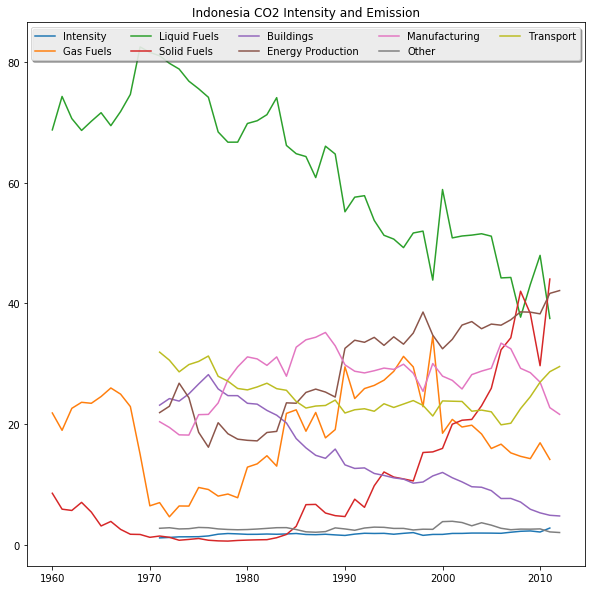

In [25]:
# import library
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline
nation='Indonesia'

intensity = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.ATM.CO2E.EG.ZS'})]
gas = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.ATM.CO2E.GF.ZS'})]
liquid = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.ATM.CO2E.LF.ZS'})]
solid = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.ATM.CO2E.SF.ZS'})]
build = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.CO2.BLDG.ZS'})]
energy = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.CO2.ETOT.ZS'})]
manuf = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.CO2.MANF.ZS'})]
other = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.CO2.OTHX.ZS'})]
trans = data2[
    data2['Country_Name'].isin({nation}) & 
    data2['Indicator_Code'].isin({'EN.CO2.TRAN.ZS'})]

plt.figure(figsize=(10,10))
inte, = plt.plot(intensity["year"], intensity["value"])
gas, = plt.plot(gas["year"], gas["value"])
liq, = plt.plot(liquid["year"], liquid["value"])
sol, = plt.plot(solid["year"], solid['value'])
bui, = plt.plot(build["year"], build["value"])
ene, = plt.plot(energy["year"], energy["value"])
man, = plt.plot(manuf["year"], manuf["value"])
oth, = plt.plot(other["year"], other["value"])
tra, = plt.plot(trans["year"], trans["value"])

fontP = FontProperties()
fontP.set_size("medium")
sets = [inte,gas,liq,sol,bui,ene,man,oth,tra]
lbls = ["Intensity","Gas Fuels","Liquid Fuels","Solid Fuels","Buildings", "Energy Production", 
        "Manufacturing", "Other", "Transport"]
plt.title(nation+' CO2 Intensity and Emission')
plt.legend(sets, lbls, ncol=5, fancybox=True, shadow=True,prop=fontP);

Let's create function based on the plot above:

In [26]:
def plot_source_emission(nation, meta = False):
    """
    This function will plot:
        - CO2 emissions from gaseous fuel consumption (% of total)
        - CO2 emissions from liquid fuel consumption (% of total)
        - CO2 emissions from solid fuel consumption (% of total)
        - CO2 emissions from residential buildings and commercial and public services (% of total fuel combustion)
        - CO2 emissions from electricity and heat production, total (% of total fuel combustion)
        - CO2 emissions from manufacturing industries and construction (% of total fuel combustion)
        - CO2 emissions from other sectors, excluding residential buildings and commercial and public services (% of total fuel combustion)
        - CO2 emissions from transport (% of total fuel combustion)
    Input: name of nation you want to plot. For example, 'Canada', 'Indonesia', etc. and boolean True or False
    if there is no meta, it is assumed that we will only plot the gaseous, liquid and solid fuel consumption.
    """
    intensity = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.ATM.CO2E.EG.ZS'})]
    gas = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.ATM.CO2E.GF.ZS'})]
    liquid = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.ATM.CO2E.LF.ZS'})]
    solid = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.ATM.CO2E.SF.ZS'})]
    build = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.CO2.BLDG.ZS'})]
    energy = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.CO2.ETOT.ZS'})]
    manuf = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.CO2.MANF.ZS'})]
    other = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.CO2.OTHX.ZS'})]
    trans = data2[
        data2['Country_Name'].isin({nation}) & 
        data2['Indicator_Code'].isin({'EN.CO2.TRAN.ZS'})]

    plt.figure(figsize=(10,10))
    gas, = plt.plot(gas["year"], gas["value"])
    liq, = plt.plot(liquid["year"], liquid["value"])
    sol, = plt.plot(solid["year"], solid['value'])
    ene, = plt.plot(energy["year"], energy["value"])
    tra, = plt.plot(trans["year"], trans["value"])
        
    if meta == True:
        inte, = plt.plot(intensity["year"], intensity["value"])
        bui, = plt.plot(build["year"], build["value"])
        man, = plt.plot(manuf["year"], manuf["value"])
        oth, = plt.plot(other["year"], other["value"])
        
        fontP = FontProperties()
        fontP.set_size("medium")
        sets = [inte,gas,liq,sol,ene,tra,bui,man,oth]
        lbls = ["Intensity","Gas Fuels","Liquid Fuels","Energy Production","Transport","Solid Fuels","Buildings", 
                "Manufacturing", "Other"]
        plt.title(nation+' CO2 Intensity and Emission')
        plt.legend(sets, lbls, ncol=5, fancybox=True, shadow=True,prop=fontP);
    
    else:
        
        fontP = FontProperties()
        fontP.set_size("medium")
        sets = [gas,liq,sol,ene,tra]
        lbls = ["Gas Fuels","Liquid Fuels","Solid Fuels","Energy Production","Transport"]
        plt.title(nation+' CO2 Intensity and Emission')
        plt.legend(sets, lbls, ncol=5, fancybox=True, shadow=True,prop=fontP);

## 3.3 Country with that produce the most carbon emission
Here, we will bar plot top 15 country with most emission in year 1960 and year 2011. Note: the Carbon emission for 2011 forwards are null.

C:\Users\LW130003\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


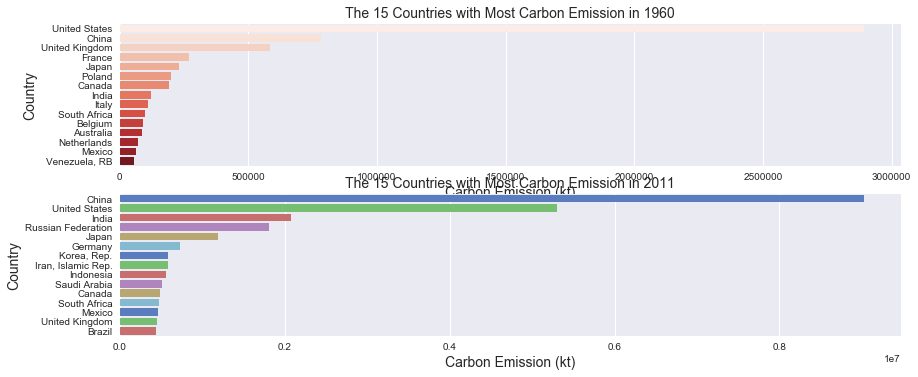

In [27]:
import seaborn as sns

#get rid of indicators that aren't countries 
lst = ['Arab World', 'Caribbean small states', 'Central Europe and the Baltics',
 'East Asia & Pacific (all income levels)',
 'East Asia & Pacific (developing only)', 'Euro area',
 'Europe & Central Asia (all income levels)',
 'Europe & Central Asia (developing only)', 'European Union',
 'Fragile and conflict affected situations',
 'Heavily indebted poor countries (HIPC)', 'High income',
 'High income: nonOECD', 'High income: OECD',
 'Latin America & Caribbean (all income levels)',
 'Latin America & Caribbean (developing only)',
 'Least developed countries: UN classification', 'Low & middle income',
 'Low income', 'Lower middle income',
 'Middle East & North Africa (all income levels)',
 'Middle East & North Africa (developing only)', 'Middle income',
 'North America' 'OECD members' ,'Other small states',
 'Pacific island small states', 'Small states', 'South Asia',
 'Sub-Saharan Africa (all income levels)',
 'Sub-Saharan Africa (developing only)' ,'Upper middle income' ,'World', 'North America', 'OECD members']

data3 = data2[~data2['Country_Name'].isin(lst)]

"""
mostemi_1960 = data3[
    (data3['year'].isin({1960})) & 
    (data3['Indicator_Code'].isin({'EN.ATM.CO2E.KT'}))].sort_values(by = 'value', ascending = False)[:15]
Does not work for some reason. It return empty dataframe
"""
x = data3[data3['Indicator_Code'].isin({'EN.ATM.CO2E.KT'})]

mostemi_1960 = x[x.year.isin({'1960'})].sort_values(by = 'value', ascending = False)[:15]
mostemi_2011 = x[x.year.isin({'2011'})].sort_values(by = 'value', ascending = False)[:15]

lowestemi_1960 = x[x.year.isin({'1960'})].sort_values(by = 'value', ascending = True)[:15]
lowestemi_2011 = x[x.year.isin({'2011'})].sort_values(by = 'value', ascending = True)[:15]

fig = plt.figure(figsize=(14,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)

graph1 = sns.barplot(x = "value", y = "Country_Name", palette = "Reds", data = mostemi_1960, ax=ax1)
ax1.set_xlabel('Carbon Emission (kt)', fontsize = 14)
ax1.set_ylabel('Country',  fontsize=14)
ax1.set_title('The 15 Countries with Most Carbon Emission in 1960', fontsize = 14)

graph2 = sns.barplot(x = "value", y = "Country_Name", palette = "muted", data = mostemi_2011, ax=ax2)
ax2.set_xlabel('Carbon Emission (kt)', fontsize = 14)
ax2.set_ylabel('Country',  fontsize=14)
ax2.set_title('The 15 Countries with Most Carbon Emission in 2011', fontsize = 14);

C:\Users\LW130003\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


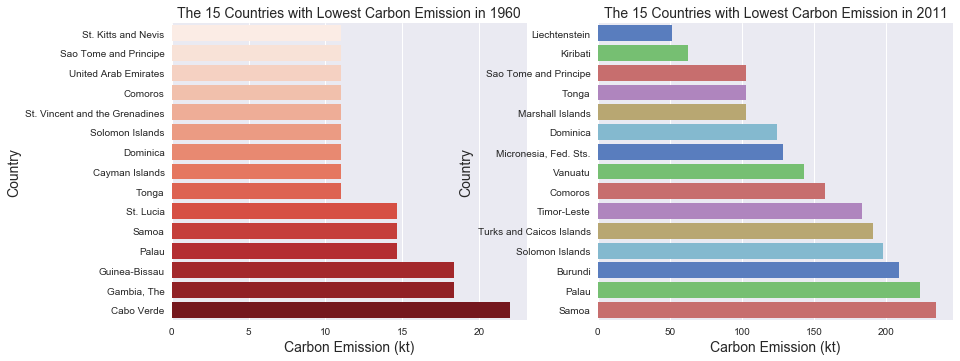

In [28]:
fig = plt.figure(figsize=(14,12))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)
ax3 = fig.add_subplot(221)
ax4 = fig.add_subplot(222)

lowestemi_1960 = x[x.year.isin({'1960'})].sort_values(by = 'value', ascending = True)[:15]
lowestemi_2011 = x[x.year.isin({'2011'})].sort_values(by = 'value', ascending = True)[:15]

graph3 = sns.barplot(x = "value", y = "Country_Name", palette = "Reds", data = lowestemi_1960, ax=ax3)
ax3.set_xlabel('Carbon Emission (kt)', fontsize = 14)
ax3.set_ylabel('Country',  fontsize=14)
ax3.set_title('The 15 Countries with Lowest Carbon Emission in 1960', fontsize = 14)

graph4 = sns.barplot(x = "value", y = "Country_Name", palette = "muted", data = lowestemi_2011, ax=ax4)
ax4.set_xlabel('Carbon Emission (kt)', fontsize = 14)
ax4.set_ylabel('Country',  fontsize=14)
ax4.set_title('The 15 Countries with Lowest Carbon Emission in 2011', fontsize = 14);

Let's print the dataframe:

In [29]:
# Take important part and merge dataframe to make it easier to read
pd.merge(mostemi_1960[['Country_Name','value','year']], mostemi_2011[['Country_Name','value','year']], on=['Country_Name'])

,Country_Name,value_x,year_x,value_y,year_y
0,United States,2890696.100,1960,5305569.614,2011
1,China,780726.302,1960,9019518.215,2011
2,United Kingdom,584299.780,1960,448235.745,2011
3,Japan,232781.160,1960,1187656.959,2011
4,Canada,192895.201,1960,485463.129,2011
5,India,120581.961,1960,2074344.893,2011
6,South Africa,97934.569,1960,477241.715,2011
7,Mexico,63116.404,1960,466548.743,2011


In [30]:
# Compute change of carbon emission
x = pd.merge(mostemi_1960[['Country_Name','value','year']], mostemi_2011[['Country_Name','value','year']], on=['Country_Name'])
round(x.value_y / x.value_x)
print(x.Country_Name.values)

['United States' 'China' 'United Kingdom' 'Japan' 'Canada' 'India'
 'South Africa' 'Mexico']


This 7 countries are the country that are generally produce most emission in between 1960 - 2011.

In [31]:
# Take important part and merge dataframe to make it easier to read
pd.merge(lowestemi_1960[['Country_Name','value','year']], lowestemi_2011[['Country_Name','value','year']], on=['Country_Name'])

,Country_Name,value_x,year_x,value_y,year_y
0,Sao Tome and Principe,11.001,1960,102.676,2011
1,Comoros,11.001,1960,157.681,2011
2,Solomon Islands,11.001,1960,198.018,2011
3,Dominica,11.001,1960,124.678,2011
4,Tonga,11.001,1960,102.676,2011
5,Samoa,14.668,1960,234.688,2011
6,Palau,14.668,1960,223.687,2011


In [32]:
x = pd.merge(lowestemi_1960[['Country_Name','value','year']], lowestemi_2011[['Country_Name','value','year']], on=['Country_Name'])
print(round(x.value_y / x.value_x))
print(x.Country_Name.values)

0     9.0
1    14.0
2    18.0
3    11.0
4     9.0
5    16.0
6    15.0
dtype: float64
['Sao Tome and Principe' 'Comoros' 'Solomon Islands' 'Dominica' 'Tonga'
 'Samoa' 'Palau']


|Variable name  | Variable definition|
|:---:|:---:|
|Identifier    | variables	|
|countrycode	  | 3-letter ISO country code|
|country	      | Country name|
|currency_unit |	Currency unit|

This 6 countries are the country that are generally produce lowest emission in between 1960 - 2011.

Based on the plots and dataframe we could conclude that the carbon emission has grown exponentially from 1960 to 2011. Even country with lowest emission rate have its carbon emission are multiplied by 9 - 18 times.

|Country  | Increase|Country  | Increase|
|:---:|:---:|:---:|:---:|
|'United States'|2.0x|'Sao Tome and Principe'|9.0x|
|'China'|12x|'Comoros'|14.0x|
|'United Kingdom'|1.x|'Solomon Island|18.0x|
|'Japan'|5.0x|'Dominica'|11.0x|
|'Canada'|3.0x|'Tonga'|9.0x|
|'India'|17.0x|'Samoa'|16.0x|
|'South Africa'|5.0x|'Palau'|15.0x|
|'Mexico'|7.0x|

Let's plot CO2 source emision for the country in dataframe to further investigate the carbon emission rate:

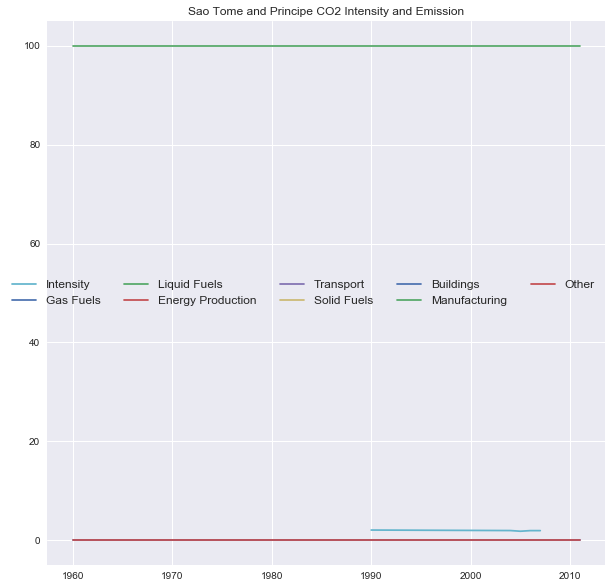

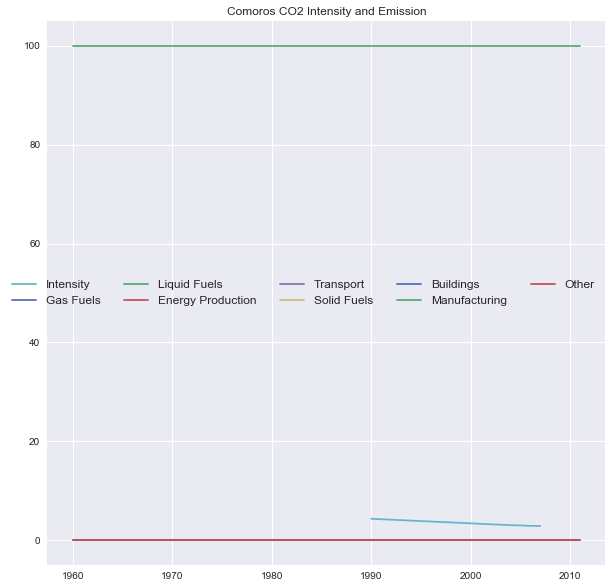

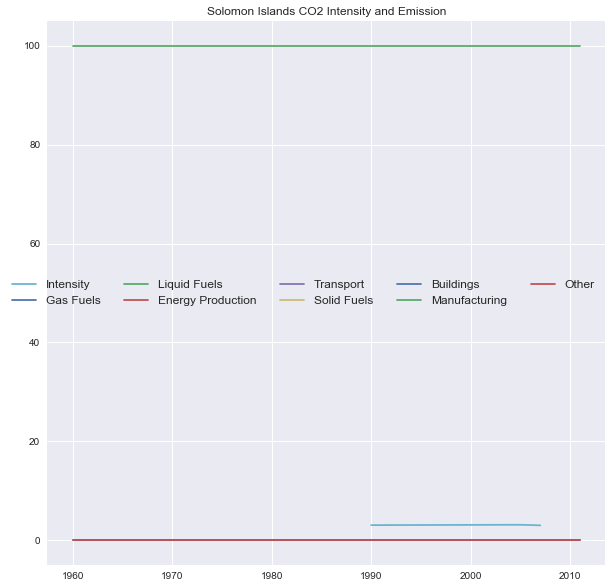

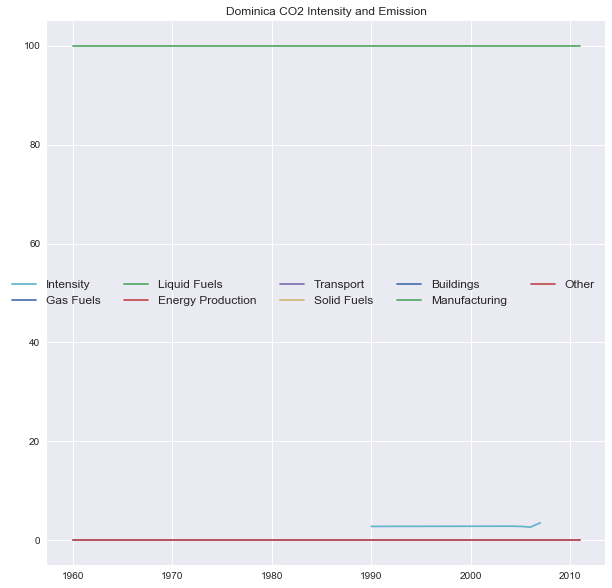

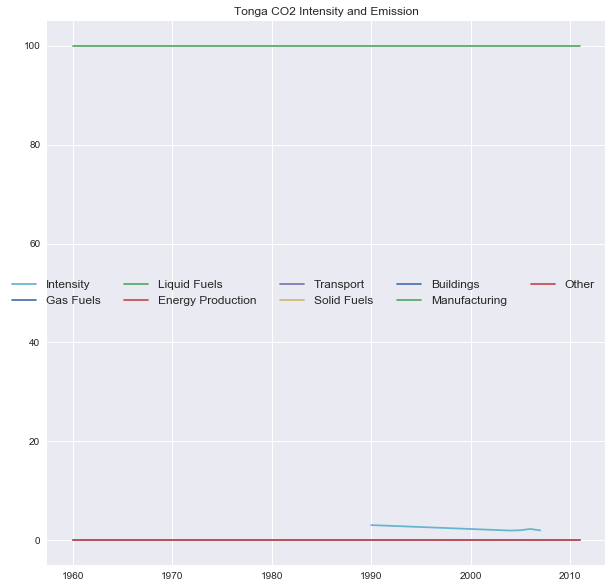

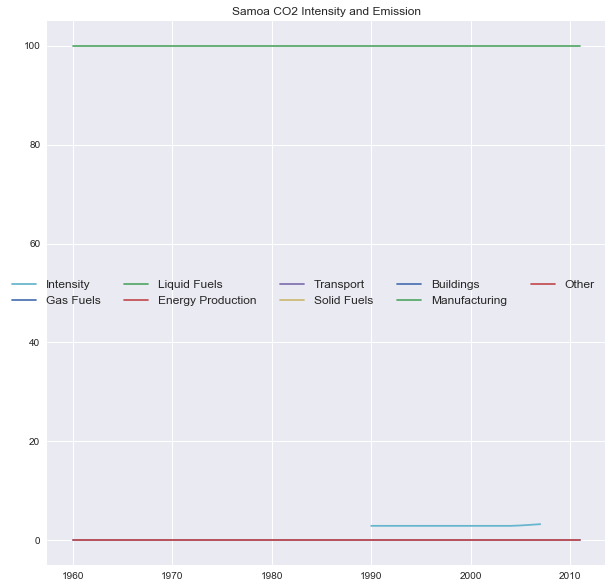

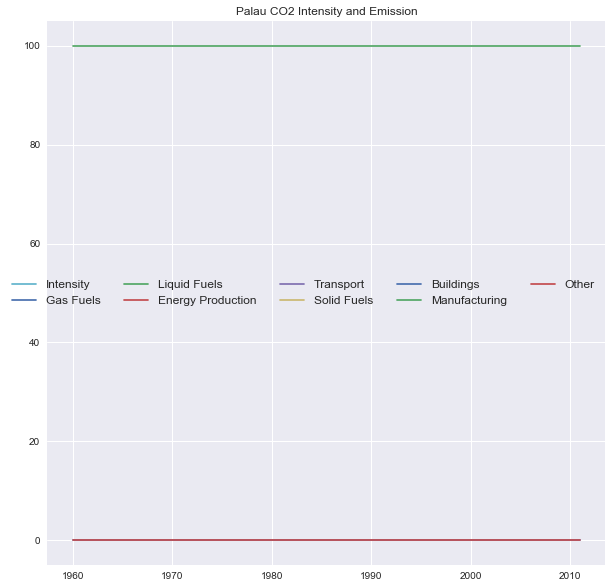

In [33]:
# Lowest emission
pl2 = ['Sao Tome and Principe', 'Comoros', 'Solomon Islands', 'Dominica',
       'Tonga', 'Samoa', 'Palau']
for p in pl2:
    plot_source_emission(p, True)

Comparing the plot_emission_source and checking the dataframe, we could conclude that country with lowest carbon emission are highly incomplete. Thus, we will only use the plot from country with most carbon emission for analysis. 
- First plot UK, USA and Canada x  as they have small increase in carbon emission (1,2 and 3x).
- Next plot China and India as they have exponential increase in carbon emission (12x and 17x).
- Then we will mass plot the rest.

**Note**: we will plot the Energy production, transport and 3 main source of consumption alone (Gas, Liquid, Solid fuels first), then plot it together with other meta (others, manufacture, building, etc.).

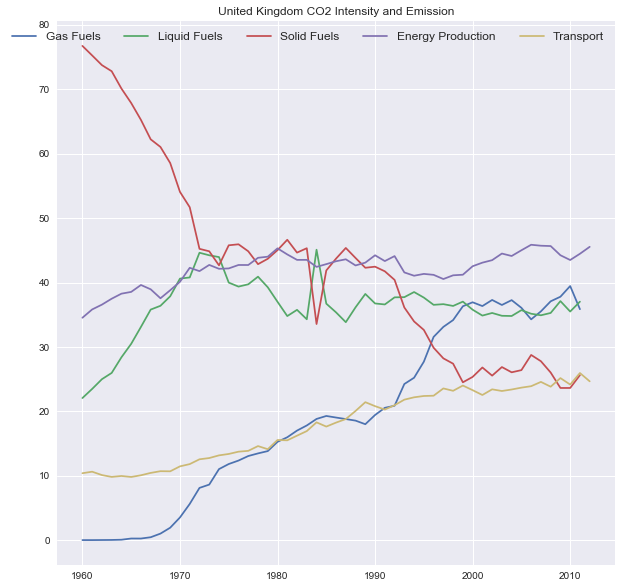

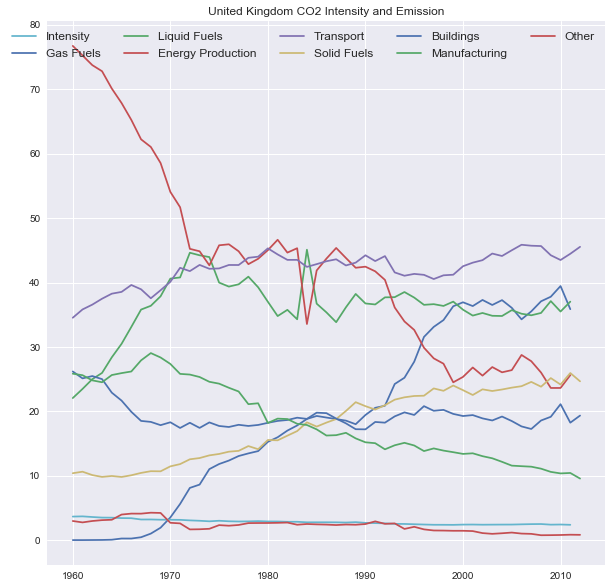

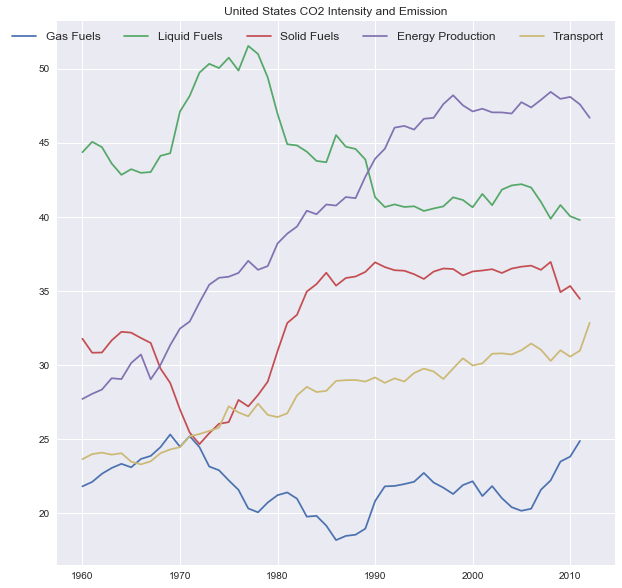

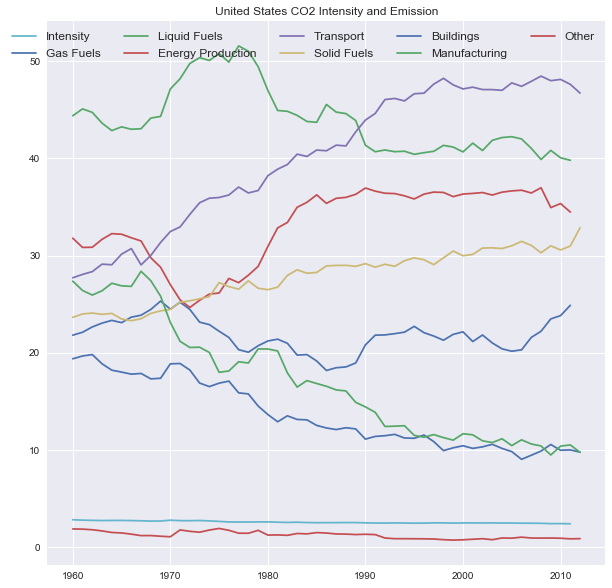

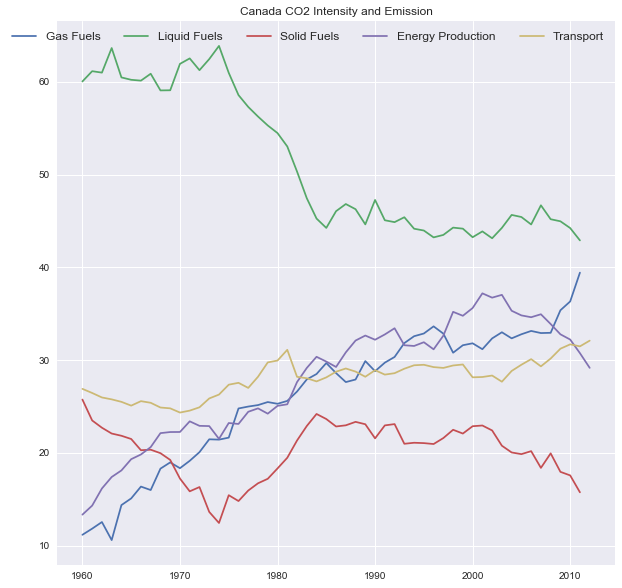

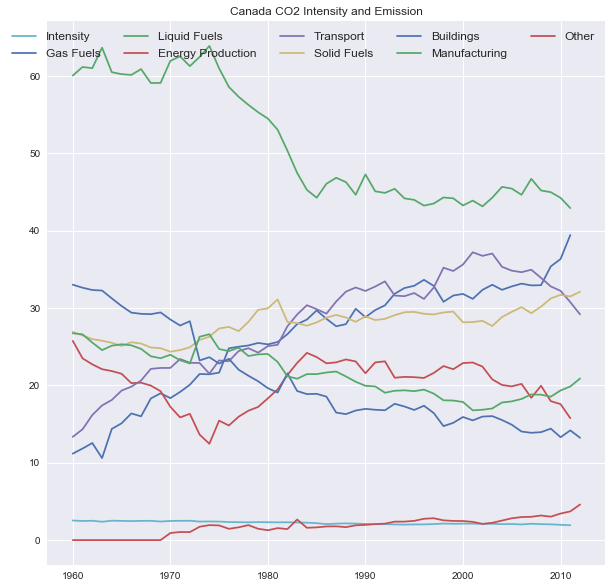

In [34]:
# plot United Kingdom, USA, Canada (1,2,3x increase)
pl1 = ['United Kingdom', 'United States', 'Canada']
for p in pl1:
    plot_source_emission(p)
    plot_source_emission(p, True) 

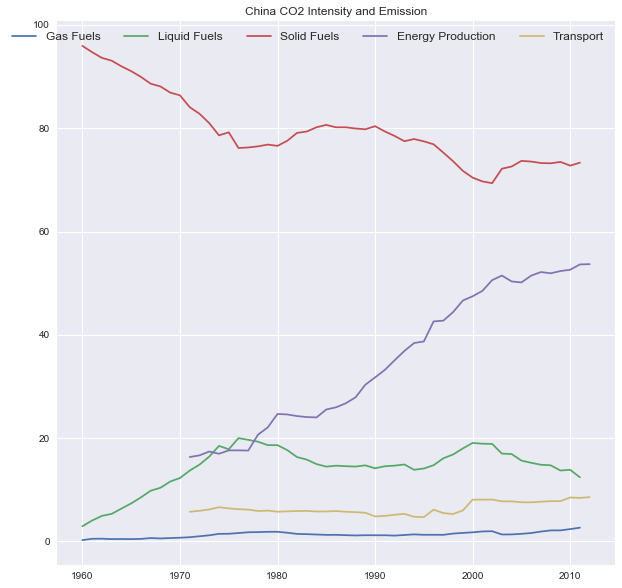

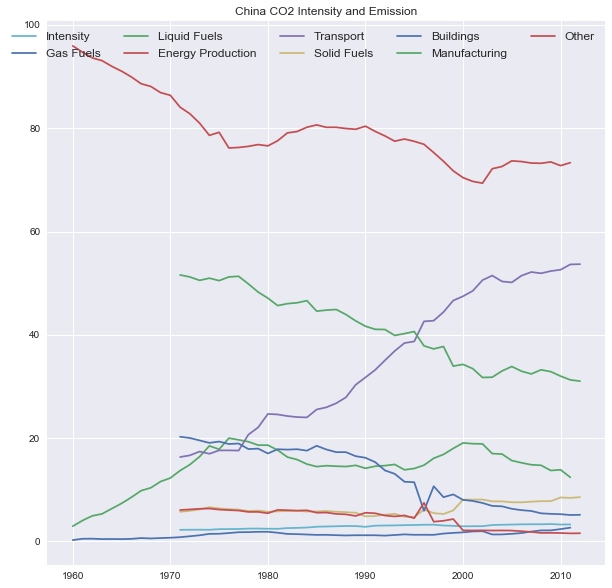

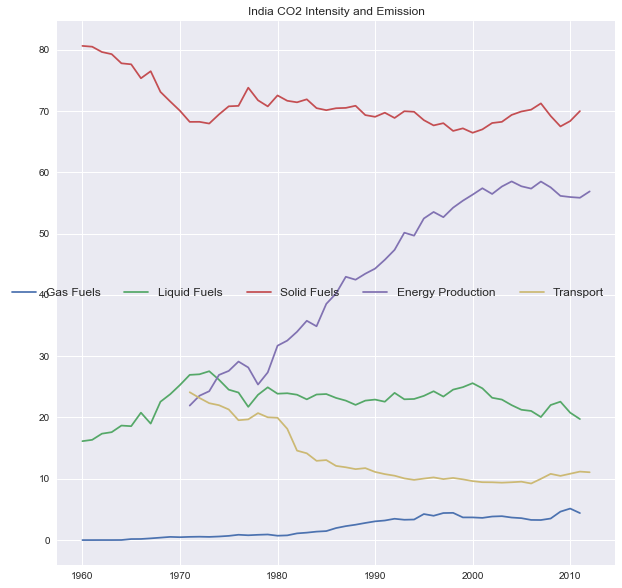

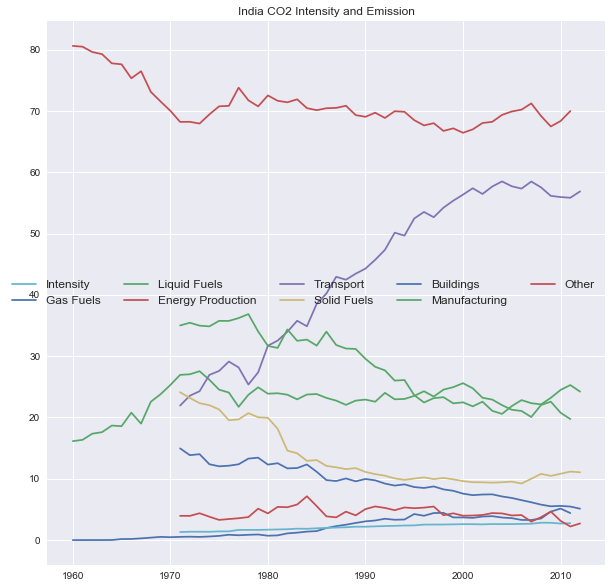

In [35]:
# plot China and India (12, 17x increase)
pl2 = ['China', 'India']
for p in pl2:
    plot_source_emission(p)
    plot_source_emission(p, True) 

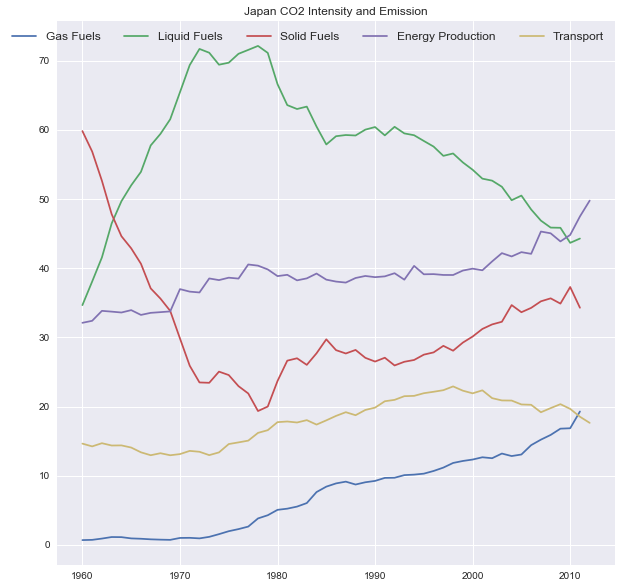

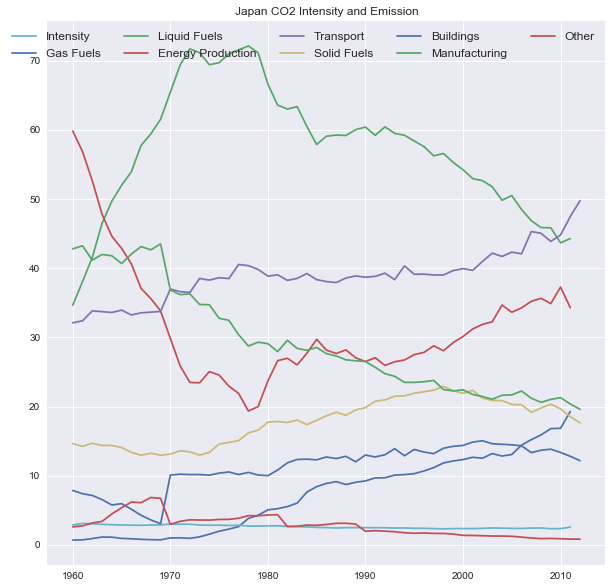

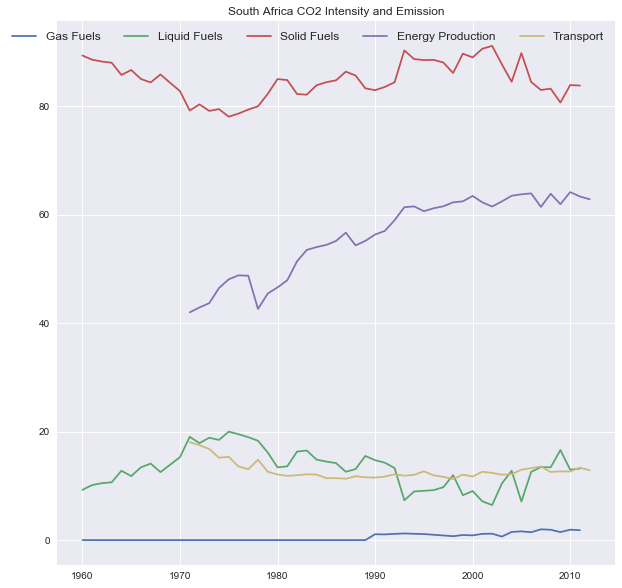

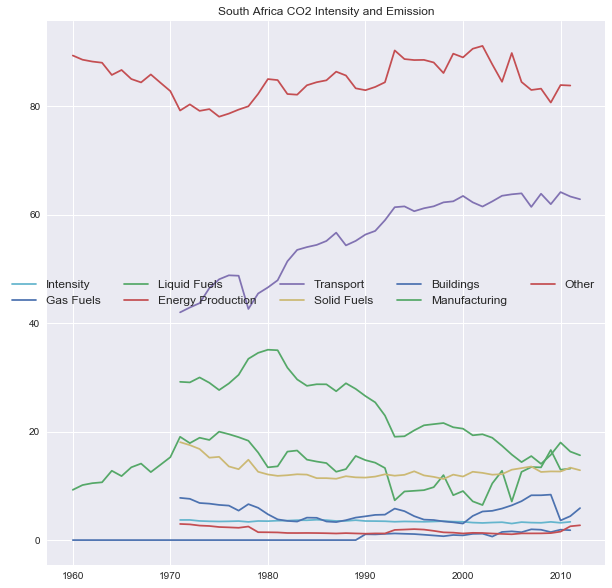

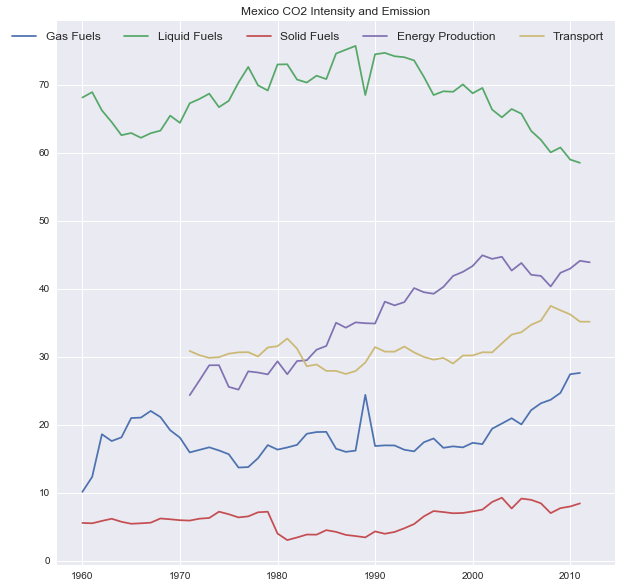

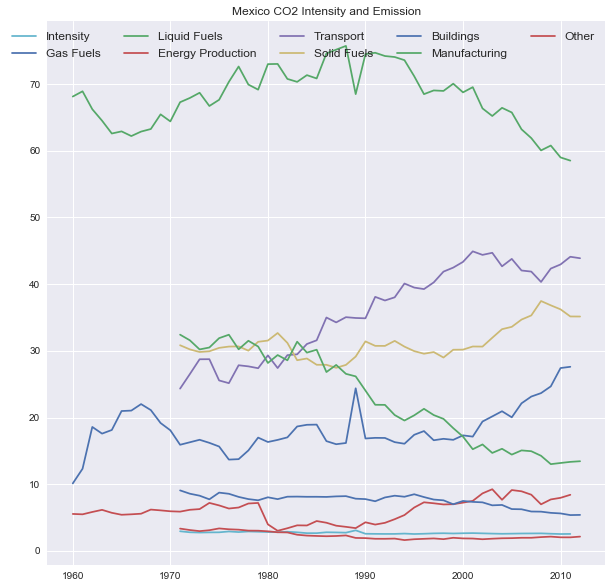

In [36]:
# Plot the rest (5-7x increase)
pl3 = ['Japan', 'South Africa', 'Mexico']
for p in pl3:
    plot_source_emission(p)
    plot_source_emission(p, True) 

From all this plot we could conclude:
1. Gas fuels consumption increase and reduce either or both solid and liquid fuel gas consumption. Most likely, gas fuel is more efficient and environmental friendly than the solid and liquid fuels.
2. Energy production is proportional with carbon emission. In other words, the more energy production, the more carbon emission is.
3. Transport have weak correlation with carbon emission.

More things to do:
1. Heatmap, check the correlation between indicators. You need to transform the long data to wide with indicators as columns.